In [7]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [8]:
ntuples = '20170526'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170526/AllNonResSig_20170526.root


In [14]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
###### REMOVING DR(hh) since not SAFE
### remove DR if you don't want to use it
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr'.split(",")
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


utils.preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
#weights_sig=utils.preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_sig=utils.preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_bkg,weights_sig=utils.preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg = utils.preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
X_sig,y_sig,weights_sig = utils.preprocessing.randomize(X_sig,y_sig,weights_sig)

print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=utils.preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = utils.preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr']
(2254174, 12)
(2254174, 1)
(1922962, 12)
(1922962, 1)


In [15]:
########final optimization with all fixed#######

from sklearn.externals import joblib
import xgboost as xgb

clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=None, n_estimators=1500, nthread=20,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH/Training/output_files/allMC_resWeighting_F_noDR.pkl'), compress=9)

['/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/output_files/allMC_resWeighting_F_noDR.pkl']

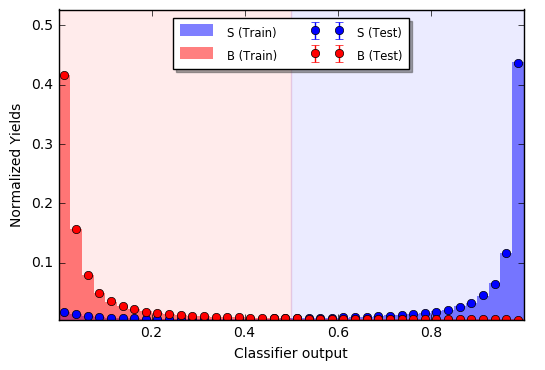

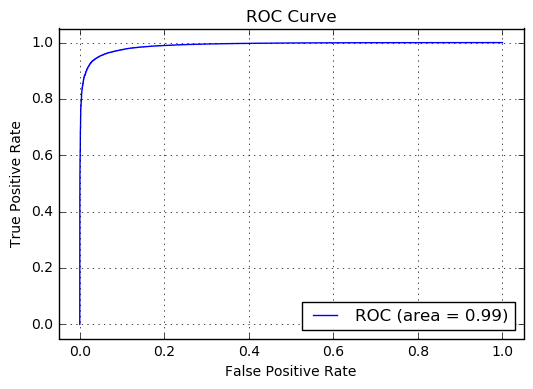

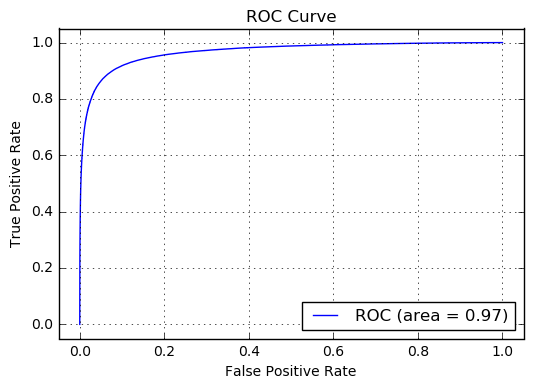

In [16]:
import matplotlib.pyplot as plt

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_noDR")
plt.show()
fpr_gJets_2ndtest_2,tpr_gJets_2ndtest_2 = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString="xgbr_gJets_resWeighting_optimized_noDR",weights=w_total_test)
plt.show()
fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString="xgbr_diphotons_resWeighting_optimized_noDR",weights=w_total_test)
plt.show()

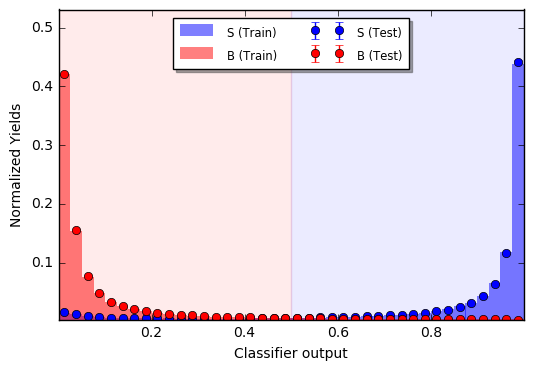

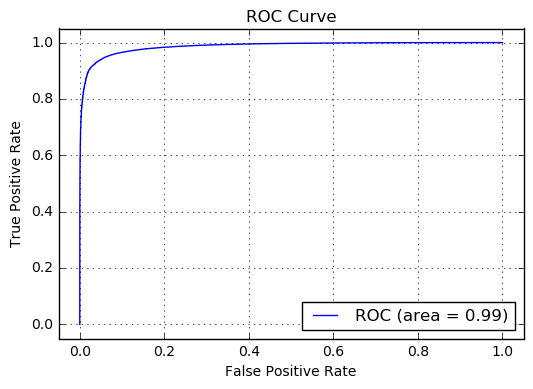

/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.py:557: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weights != None:
/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.py:568: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if weights == None:


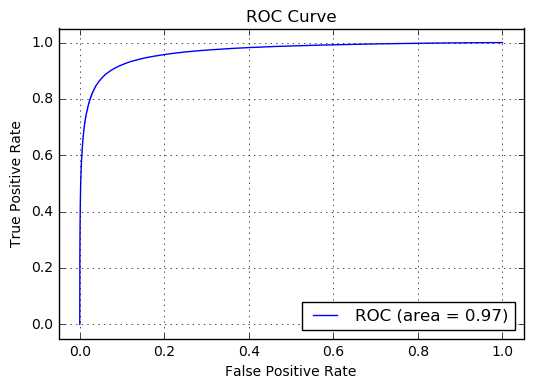

In [13]:
#####warning!!!this was trained using DR, if you rerun the program you have to add it
import matplotlib.pyplot as plt

utils.plotting.plot_classifier_output(clf_2,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg_resWeight_optimized_withDR")
plt.show()
fpr_gJets_2,tpr_gJets_2 = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf_2,-2,outString="xgbr_gJets_resWeighting_optimized_withDR",weights=w_total_test)
plt.show()
fpr_dipho_2,tpr_dipho_2 = utils.plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf_2,-1,outString="xgbr_diphotons_resWeighting_optimized_withDR",weights=w_total_test)
plt.show()